In [ ]:
!pip install scikit-dimension
!pip install umap-learn
!pip install --upgrade scikit-learn
!pip install --upgrade gap-stat


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade gap-stat


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('./drive')


Mounted at ./drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

In [ ]:
!cp 'drive/MyDrive/optimizer/data/R24.zip' R24.zip

In [ ]:
!unzip R24.zip

Archive:  R24.zip
  inflating: R24.txt                 


In [ ]:
!head R24.txt

5 442037 17 80 0
6 4 5 6 3 3 4 6 3 5 6 6 6 3 6 3 5
-12.414975878319538 6.451257783681377 -0.062902622443676 19.860121914848026 -11.744378064821891
-7.393401221926462 8.158995906079436 0.404055318874846 5.973969023294856 -21.991719077058345
-8.999182515638003 17.115923815745838 0.439189845608123 20.381894609431843 -15.704045864462724
-8.388726890575502 18.402374748911946 0.509096986228516 27.804466310059428 -5.942699608902973
1.412457497040006 -13.111615553849623 0.114781844534006 -5.687570733681045 6.724785552631902
-1.682648867314407 11.168144678042365 0.474623918715262 28.379428100662391 18.463731434793758
2.586761760795954 31.490996865016527 1.069144107845982 27.401843750264671 1.853268923796068
6.218236831864071 28.690912262398005 1.252558962978791 27.399073410167652 13.029253636851738


In [ ]:
with open('R24.txt') as fp:
  line = fp.readline()
  line = line.split(' ')
  d, n, m, k, p = [int(item) for item in line]
  line = fp.readline()
  line = line.split(' ')
  K = [int(item) for item in line]


In [ ]:
!tail -n +3 R24.txt > R24_clean.txt

In [ ]:
vectors = np.fromfile('R24_clean.txt', sep=' ').reshape(n, -1)

In [ ]:
vectors

array([[-1.24149759e+01,  6.45125778e+00, -6.29026224e-02,
         1.98601219e+01, -1.17443781e+01],
       [-7.39340122e+00,  8.15899591e+00,  4.04055319e-01,
         5.97396902e+00, -2.19917191e+01],
       [-8.99918252e+00,  1.71159238e+01,  4.39189846e-01,
         2.03818946e+01, -1.57040459e+01],
       ...,
       [ 5.95891019e+02,  8.44736719e+01, -1.21322268e+02,
         6.96902250e+01,  6.54763764e+01],
       [ 5.30503020e+02,  5.50430504e+01, -1.06673473e+02,
         1.90921786e+00,  4.02880847e+01],
       [ 2.86324553e+02,  4.89032866e+01,  1.00463906e+01,
        -3.85371050e+01,  3.53159199e+01]])

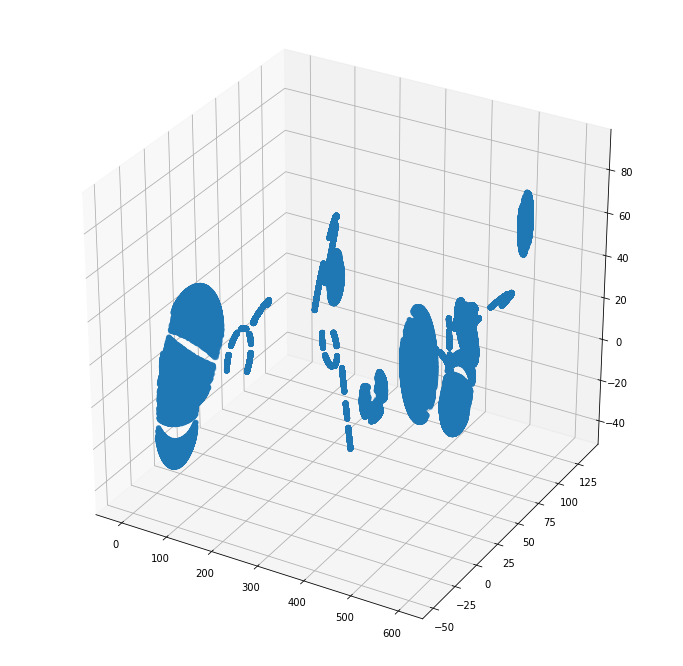

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')


ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 3])
_ = plt.show()

In [ ]:
from sklearn.neighbors import KDTree
from numba import jit, njit

smoothed = np.copy(vectors)



def smoother(data, tree):
  original = np.copy(data)
  for i in tqdm(range(len(data))):
    _, ind = tree.query(data[i:i+1], k=64+step)
    ind = ind[0]
    t1 = original[ind, :].mean(axis=0)
    data[i:i+1] = data[i] + np.random.uniform(0.0, 1.0)*(t1 - data[i])
  return data



  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

In [ ]:
steps = 8
for step in range(steps):
  tree = KDTree(smoothed)
  smoothed = smoother(smoothed, tree)

  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

  0%|          | 0/442037 [00:00<?, ?it/s]

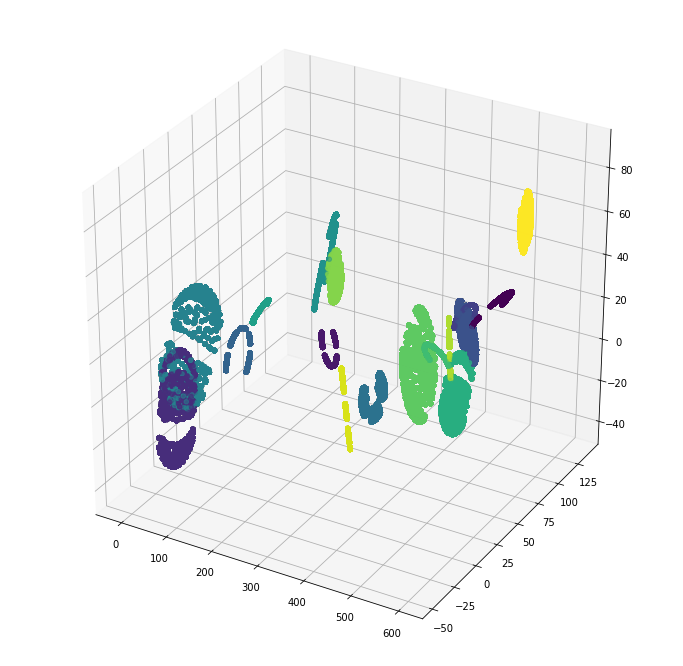

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(smoothed[:, 0], smoothed[:, 1], smoothed[:, 3], c=labels)
_ = plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

from sklearn.cluster import SpectralClustering


gmm = GaussianMixture(n_components=m, covariance_type='spherical', 
                      random_state=8, n_init=16,
                      verbose=2)

gmm.fit(smoothed)

labels = gmm.predict(smoothed)

Initialization 0
Initialization converged: True	 time lapse 4.19797s	 ll -20.55216
Initialization 1
Initialization converged: True	 time lapse 10.83697s	 ll -20.78343
Initialization 2
Initialization converged: True	 time lapse 8.59604s	 ll -20.54012
Initialization 3
Initialization converged: True	 time lapse 3.62438s	 ll -20.60073
Initialization 4
Initialization converged: True	 time lapse 3.85523s	 ll -20.62289
Initialization 5
Initialization converged: True	 time lapse 3.77235s	 ll -20.71881
Initialization 6
Initialization converged: True	 time lapse 5.86930s	 ll -20.42493
Initialization 7
Initialization converged: True	 time lapse 4.84162s	 ll -20.39900
Initialization 8
Initialization converged: True	 time lapse 4.41751s	 ll -20.46825
Initialization 9
Initialization converged: True	 time lapse 3.91319s	 ll -20.47329
Initialization 10
Initialization converged: True	 time lapse 8.25545s	 ll -20.64121
Initialization 11
Initialization converged: True	 time lapse 3.69284s	 ll -20.76023
I

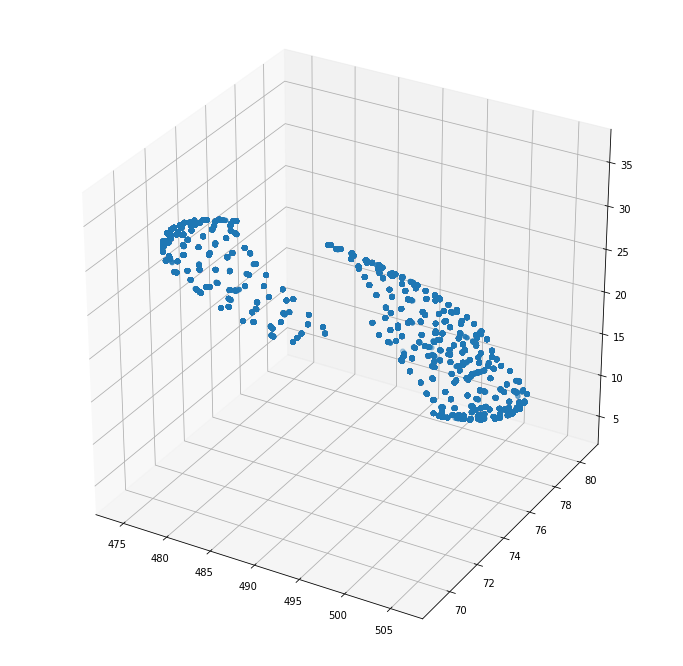

In [ ]:
from random import choices

s_smoothed = smoothed[labels==4]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(s_smoothed[:, 0], s_smoothed[:, 1], s_smoothed[:, 3])
_ = plt.show()

In [ ]:
def top_k_outliers(vectors, k):
  scores = gmm.score_samples(vectors)
  top_k = np.argpartition(-scores, -k)[-k:]
  return top_k, scores[top_k]

In [ ]:
outlier_ind = []

In [ ]:
labels = gmm.predict(smoothed)
if p > 0:
  outlier_ind, _ = top_k_outliers(vectors, p)
  labels[outlier_ind] = -1

In [ ]:
labels

array([ 6,  6,  6, ..., 14, 38, 43])

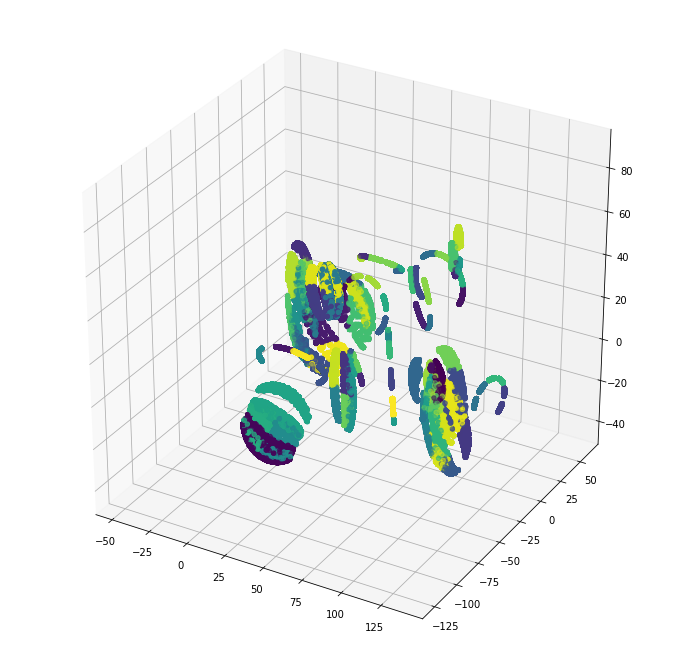

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(smoothed[:, 1], smoothed[:, 2], smoothed[:, 3], c=labels)
_ = plt.show()

In [ ]:
from numba import njit, jit

@jit
def noisy_center_radius(points, k):
  dist_matrix = np.zeros((points.shape[0], points.shape[0]))
  for i in range(points.shape[0]):
    for j in range(i):
      dist = np.linalg.norm(points[i] - points[j])
      dist_matrix[i, j] = dist
  dist_matrix = dist_matrix.reshape(-1)
  top_k_dist = np.argsort(dist_matrix)[-k:]
  rows = top_k_dist // points.shape[0]
  cols = top_k_dist % points.shape[0]
  center = 0.5*(points[cols] + points[rows]).mean(axis=0)
  radius = dist_matrix[top_k_dist].mean()/2
  return center, radius

def center_radius(points):
  dist = torch.cdist(points, points)
  ind = dist.argmax()
  row = (torch.div(ind, points.size(0), rounding_mode='floor')).item()
  col = (ind % points.size(0)).item()
  radius = (dist[row, col]/2).item()
  center = 0.5 * (points[row] + points[col])
  return center, radius


manifold_center = []
manifold_radius = []

for sphere in tqdm(range(m)):
  sampled = choices(np.where(labels==sphere)[0], k=10000)
  points = torch.from_numpy(vectors[sampled])
  # points = vectors[labels==sphere]
  center, radius = center_radius(points)
  manifold_center.append(center)
  manifold_radius.append(radius)

manifold_center = np.vstack(manifold_center)

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
gmm.means_

array([[ 570.46191036,   61.1942272 , -124.38164131,   42.19284197,
          78.39556384],
       [ 245.4560302 ,   47.50001142,   45.15267916,    6.47325441,
          34.84879746],
       [  62.69595999,  -27.54928482,   35.07101554,   -1.32935366,
          36.76842107],
       [ 391.42032156,  129.12548631,  -20.72548691,    4.33567128,
          66.27153482],
       [ 491.20218674,   75.4936475 ,  -92.95068239,   19.58480833,
          76.53080521],
       [ 102.32765143,   19.96533239,   29.46296372,    9.51824874,
          22.95418268],
       [ 304.50262749,   67.37986277,   18.25313547,  -21.33915423,
          31.49783441],
       [   4.2606708 ,   13.17474328,    0.6802797 ,    5.6376699 ,
          -2.96903409],
       [ 181.33389632,   77.8162213 ,    8.53228424,   38.10868077,
          50.05955462],
       [ 133.90327989,   27.4604623 ,   32.68129823,   25.80893097,
          61.65395693],
       [ 526.08675715,   41.18447563, -113.6862891 ,    2.95533943,
          56

In [ ]:
manifold_radius

[20.99913723941609,
 17.229657985100992,
 27.2097245294849,
 16.137050167478666,
 18.991937234284755,
 15.779431049606645,
 12.932431106816898,
 29.305509194734142,
 29.03798291028169,
 17.95655172734444,
 19.22361191794719,
 19.939290289680287,
 29.664154651713787,
 12.428905820914665,
 15.814490872258064,
 21.553687965091605,
 13.956037606807525]

In [ ]:
manifold_center

array([[ 565.23897479,   61.16066594, -124.56568502,   40.25663977,
          75.29899979],
       [ 247.16445495,   45.59754519,   46.60523176,   10.04572004,
          34.22577383],
       [  60.97189979,  -28.35842313,   36.44395157,   -5.69566568,
          34.21944155],
       [ 388.40458339,  129.53085401,  -25.0552267 ,    1.7084141 ,
          63.95293226],
       [ 490.10535746,   74.61897645,  -92.50756906,   20.47680083,
          72.22258675],
       [ 102.08661206,   17.64168757,   29.0154157 ,    4.03486275,
          25.86776361],
       [ 303.8557312 ,   66.51123361,   18.06557374,  -18.6776165 ,
          30.96185656],
       [   6.66348034,   12.74059712,    0.66761521,    5.37539908,
           2.5782858 ],
       [ 179.35478771,   75.94104337,   12.97050461,   32.61005999,
          49.22519659],
       [ 134.22756957,   27.0574171 ,   32.38742795,   25.50909474,
          55.84563107],
       [ 526.63801875,   43.93413099, -112.32521689,    5.65800672,
          53

In [ ]:
from scipy.optimize import minimize, differential_evolution

@njit
def loss_center_given_radius(center, points, radius):
  return (((points - center)**2).sum(axis=1) > radius**2).sum()

@jit
def estimate_corrected_radius(sphere):
  b1 = manifold_center[sphere, :] - 1.5
  b2 = manifold_center[sphere, :] + 1.5
  bounds = [(b1[i], b2[i]) for i in range(d)]
  result = differential_evolution(func=loss_center_given_radius,
                        bounds=bounds, maxiter=1500, popsize=128,
                        args=(vectors[labels==sphere], manifold_radius[sphere]))
  print(result)
  center = result.x
                        
  return center

In [ ]:
manifold_corrected_center = np.vstack([estimate_corrected_radius(sphere) for sphere in tqdm(range(k))])

  0%|          | 0/3 [00:00<?, ?it/s]

     fun: 54.0
 message: 'Optimization terminated successfully.'
    nfev: 35206
     nit: 54
 success: True
       x: array([15.08324623, 12.64592069,  2.01976313, 11.58040455, 14.21278692])
     fun: 36.0
 message: 'Optimization terminated successfully.'
    nfev: 42246
     nit: 65
 success: True
       x: array([ 93.76727217,  30.47480765,  22.63581869,  90.76137756,
       -22.79568849])
     fun: 55.0
 message: 'Optimization terminated successfully.'
    nfev: 25606
     nit: 39
 success: True
       x: array([171.77996786,  -3.28518783,  36.23431569, 140.96755519,
       -93.97977914])


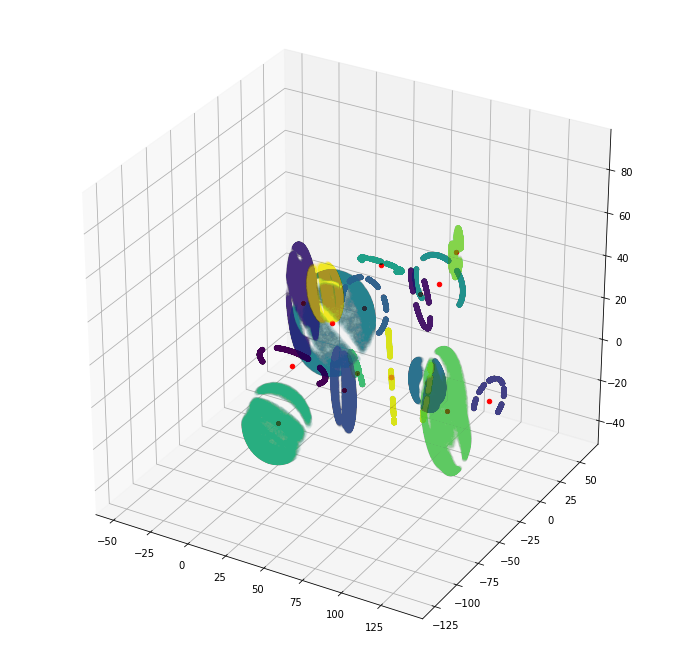

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(vectors[:, 1], vectors[:, 2], vectors[:, 3], c=labels, alpha=0.01)
for sphere in range(m):
  ax.scatter(manifold_center[sphere, 1], manifold_center[sphere, 2], manifold_center[sphere, 3], c='red')

_ = plt.show()

In [ ]:
import skdim.id as intd

manifold_dims = []

for sphere in tqdm(range(m)):
  lpca = intd.lPCA().fit_pw(vectors[labels==sphere], n_neighbors = 64, n_jobs = 1)
  # pca = intd.DANCo().fit(vectors[labels==sphere])
  # manifold_dims.append(pca.dimension_)
  manifold_dims.append(int(np.round(lpca.dimension_pw_.mean())))
  

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
manifold_dims

[5, 5, 2, 5, 2, 5, 2, 2, 5, 5, 2, 5, 2, 2, 5, 5, 2]

In [ ]:
estimated_K = [3, 4, 3, 6, 3, 5, 3, 3, 3, 6, 3, 6, 4, 3, 6, 6, 6]

In [ ]:
def match_K(spec, est):
  sorted_K = np.array(sorted(spec))
  return sorted_K[np.array(est).argsort()]

matched_K = match_K(K, estimated_K)
matched_K

array([3, 3, 3, 4, 5, 5, 6, 6, 3, 6, 4, 3, 5, 6, 6])

In [ ]:
K

[5, 3, 6, 3, 6, 5, 3, 6, 4, 5, 6, 4, 6, 3, 6, 6, 3]

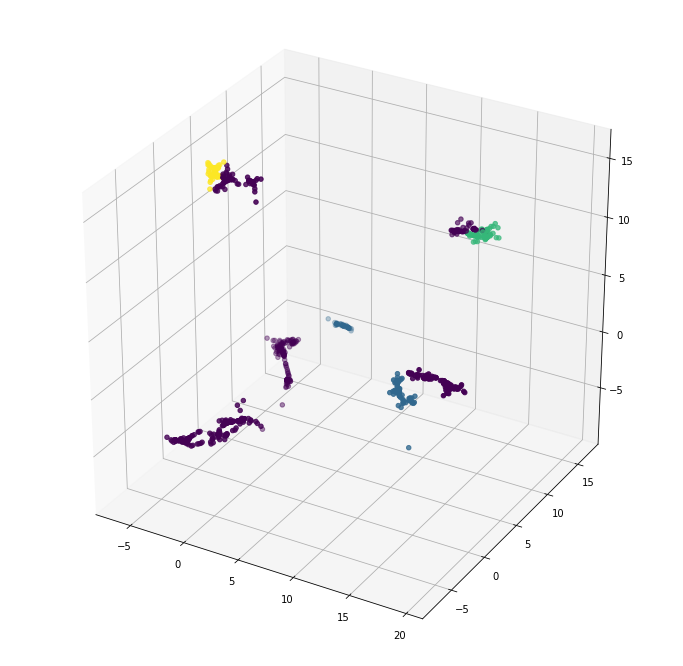

In [ ]:
from sklearn.cluster import SpectralClustering
from umap import UMAP





reducer = UMAP(n_components=3,
                densmap=True, n_neighbors=128, min_dist=0.0)

points_red = reducer.fit_transform(points)

cluster = SpectralClustering(n_clusters=4, random_state=0, affinity='nearest_neighbors')
cluster.fit(points_red)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(points_red[:, 1], points_red[:, 2], points_red[:, 0], c=cluster.labels_)
_ = plt.show()

In [ ]:
def estimate_n_cluster(sphere):
  points = vectors[labels==sphere]
  
  reducer = UMAP(n_components=manifold_dims[sphere],
                 densmap=True, n_neighbors=128, min_dist=0.0)
  
  points_red = reducer.fit_transform(points)

  n_clusters = optimalK(points_red, cluster_array=np.arange(2, 10))

  return n_clusters

estimated_n_clusters = []

for sphere in tqdm(range(m)):
  estimated_n_clusters.append(estimate_n_cluster(sphere))

In [ ]:
K = matched_K

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine


sub_clusters = []
for sphere in tqdm(range(m)):
  points = smoothed[labels==sphere]
  original_index = np.where(labels==sphere)[0]
  cluster = SpectralClustering(n_clusters=K[sphere], random_state=0, affinity='nearest_neighbors')
  cluster.fit(points)
  submanifold_clusters = []
  for subc in range(K[sphere]):
    submanifold_clusters.append(original_index[np.where(cluster.labels_ == subc)])
  sub_clusters.append(submanifold_clusters)

  0%|          | 0/17 [00:00<?, ?it/s]

IndexError: ignored

In [ ]:
len(estimated_K)

15

In [ ]:
from numba import njit
from sklearn.decomposition import PCA

@njit
def get_best_fitting_plane_vector(centered, dim):

    # Calculate the covariance matrix of the coordinates
    covariance_matrix = np.cov(centered, rowvar=False) # Variables = columns

    # Calculate the eigenvalues & eigenvectors of the covariance matrix
    e_val, e_vect = np.linalg.eig(covariance_matrix)

    # The normal vector to the plane is the eigenvector associated to the minimum eigenvalue
    min_eval = np.argsort(e_val)[:dim]
    normal_vector = e_vect[:, min_eval]

    return normal_vector

def get_best_fitting_plane_vector_pca(centered, dim):

    pca = PCA(n_components=d)

    pca.fit(centered)

    normal_vector = pca.components_[-dim:]

    return normal_vector.T

In [ ]:
affine_a = []
affine_b = []

for sphere in tqdm(range(m)):
  points = vectors[labels==sphere]
  shift = points.mean(axis=0)
  centered = points - shift
  a = get_best_fitting_plane_vector_pca(centered, d-manifold_dims[sphere])
  b = a.T @ shift
  affine_a.append(a)
  affine_b.append(b)


  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
affine_a[2]

array([[-0.03147653, -0.81972533, -0.5419059 ,  0.13710001, -0.12083543],
       [-0.99863656,  0.0149677 ,  0.02000865, -0.0376126 ,  0.02619032],
       [ 0.00469793, -0.03370279, -0.02968989,  0.46259449,  0.88541905],
       [ 0.04125346, -0.29731515,  0.13877421, -0.83926533,  0.43159852],
       [-0.00321373, -0.48815385,  0.82812914,  0.24784859, -0.12028585]])

In [ ]:
affine_a

[array([[-0.5292843 , -0.35600292, -0.2431598 ],
        [-0.16854403, -0.30722614,  0.86713095],
        [-0.25585224,  0.87962075,  0.23429806],
        [ 0.78976346, -0.02327556,  0.1188636 ],
        [ 0.04758508,  0.06782037, -0.34631357]]),
 array([[ 0.6072985 ,  0.05909599, -0.6224505 , -0.35742117, -0.33541271],
        [-0.78824011, -0.07514857, -0.4617281 , -0.30436081, -0.25923327],
        [ 0.02426508, -0.05508026,  0.11975262, -0.76619948,  0.6284704 ],
        [ 0.02456926, -0.05573996,  0.61897341, -0.43340733, -0.65216517],
        [ 0.0931323 , -0.99233038, -0.04351744,  0.06863712,  0.00140559]]),
 array([[-0.03147653, -0.81972533, -0.5419059 ,  0.13710001, -0.12083543],
        [-0.99863656,  0.0149677 ,  0.02000865, -0.0376126 ,  0.02619032],
        [ 0.00469793, -0.03370279, -0.02968989,  0.46259449,  0.88541905],
        [ 0.04125346, -0.29731515,  0.13877421, -0.83926533,  0.43159852],
        [-0.00321373, -0.48815385,  0.82812914,  0.24784859, -0.12028585]]),

In [ ]:
affine_a[2]

array([[-0.03147653, -0.81972533, -0.5419059 ,  0.13710001, -0.12083543],
       [-0.99863656,  0.0149677 ,  0.02000865, -0.0376126 ,  0.02619032],
       [ 0.00469793, -0.03370279, -0.02968989,  0.46259449,  0.88541905],
       [ 0.04125346, -0.29731515,  0.13877421, -0.83926533,  0.43159852],
       [-0.00321373, -0.48815385,  0.82812914,  0.24784859, -0.12028585]])

In [ ]:
with open('output_blue.txt', 'w+') as fp:
  fp.write(f'{n} {m}\n')
  for sphere in range(m):
    fp.write(f'{manifold_dims[sphere]} {K[sphere]} Sphere\n')
    if manifold_dims[sphere] == d:
      fp.write('\n')
    else:
      for i in range(affine_a[sphere].shape[1]):
        fp.write(' '.join(affine_a[sphere][:, i].astype(str).tolist()) + '\n')
      fp.write(' '.join(affine_b[sphere].astype(str).tolist()) + '\n')
    fp.write(' '.join(manifold_center[sphere, :].astype(str).tolist()) + f' {manifold_radius[sphere]} \n')
    for subc in range(K[sphere]):
      subc_points = sub_clusters[sphere][subc]
      fp.write(f'{len(subc_points)} ')
      fp.write(' '.join((subc_points+1).astype(str).tolist()))
      fp.write('\n')
  fp.write(f'{p}')
  if p > 0:
    fp.write(' ' + ' '.join((outlier_ind+1).astype(str).tolist()))